##### HW L5

ENGN 2912V

Seokkee Min

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import jax.lax as jal
from jax import jit, grad, vmap, random, value_and_grad
import time
import sympy as sym
import matplotlib.pyplot as plt
import pickle
from jax.tree_util import tree_map, tree_flatten

In [2]:
def save(params, path):
    with open(path, 'wb') as file:
        pickle.dump(params, file)
        
def load(params, path):
    with open(path, 'rb') as file:
        loaded_params = pickle.load(file)

In [3]:
def f1 (x):
    y = 1/(1+25*x**2)
    return y

def x_uni(n, lb, ub):
    x = jnp.linspace(lb, ub, n, dtype=np.float32)
    return x


In [4]:
def f2(x):
    x = np.array(x)
    y = np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]) < jnp.pi/2:
            y[i] = jnp.pi/2 - abs(x[i])  
    y = jnp.array(y)
    return y

In [5]:
def get_random_layer_params(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    return weights, biases

def get_init_network_params(sizes, ran_key):
    keys = random.split(ran_key, len(sizes))
    return [get_random_layer_params(m, n, k) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = jnp.tanh(outputs)  
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs, x  

batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss(params, x, y):
    [preds, _] = batched_prediction(params, x)
    diff = preds - y
    return jnp.sum(diff*diff)/preds.shape[0]

@jit
def update(params, x, y, learning_rate):
    l, grads = value_and_grad(mse_loss)(params, x, y)
    [_, neu]= batched_prediction(params,x)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)], l, neu

#### Function 1

In [6]:
SEED = 1234
key = random.PRNGKey(SEED)
Niter = 30000
lr = 1e-02

num_features = 1
# num_traget = 1
num_batches = 10000
layers = [1] + [32]*2 + [1]
ran_key, func_key = random.split(key)
params = get_init_network_params(layers, ran_key)

x_train = x_uni(num_batches, -1, 1)
x_train = x_train.reshape((num_batches, num_features))
y_train = f1(x_train)

for i in range(0, Niter+1):
    params, loss, neu = update(params, x_train, y_train, lr)
    if i % 2000 == 0:
        print(f"{i=} and {loss=}\n")

i=0 and loss=Array(0.15867558, dtype=float32)

i=2000 and loss=Array(0.07904739, dtype=float32)

i=4000 and loss=Array(0.07245445, dtype=float32)

i=6000 and loss=Array(0.03388987, dtype=float32)

i=8000 and loss=Array(0.02164098, dtype=float32)

i=10000 and loss=Array(0.01412479, dtype=float32)

i=12000 and loss=Array(0.00787925, dtype=float32)

i=14000 and loss=Array(0.00397272, dtype=float32)

i=16000 and loss=Array(0.00197214, dtype=float32)

i=18000 and loss=Array(0.00104207, dtype=float32)

i=20000 and loss=Array(0.00062154, dtype=float32)

i=22000 and loss=Array(0.00042806, dtype=float32)

i=24000 and loss=Array(0.00033329, dtype=float32)

i=26000 and loss=Array(0.00028131, dtype=float32)

i=28000 and loss=Array(0.00024818, dtype=float32)

i=30000 and loss=Array(0.00022376, dtype=float32)



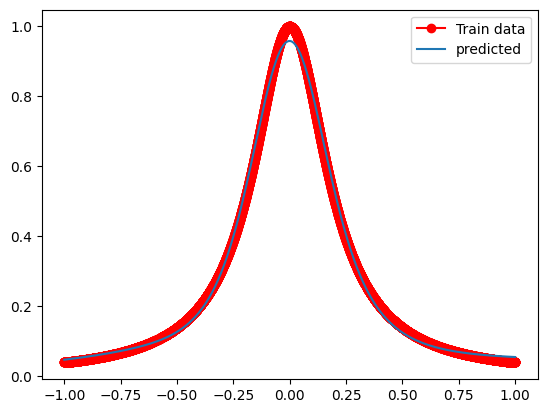

In [7]:
x_pred = jnp.linspace(-1, 1, 10000)
x_pred = x_pred.reshape((10000, num_features))
[y_pred, _] = batched_prediction(params, x_pred)
plt.plot(x_train, y_train, "-ro", label="Train data")
plt.plot(x_pred, y_pred, label="predicted")
plt.legend()

#### Hat Function

In [8]:
x_train2 = x_uni(num_batches, -np.pi, np.pi)
y_train2 = f2(x_train2)
x_train2 = x_train2.reshape((num_batches, num_features))
y_train2 = y_train2.reshape((num_batches, num_features))

In [9]:
Nmodes = 5
L = np.pi
n = len(x_train2)
nq = int(np.floor(n/4))
dx = x_train2[1] - x_train2[0]

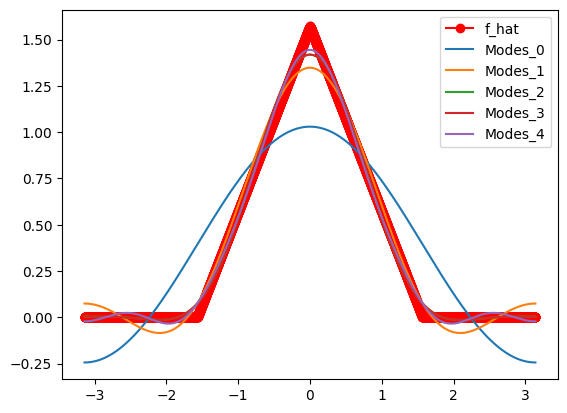

In [10]:
A0 = np.sum(y_train2 * np.ones_like(x_train2))*dx
fa = A0/2
A = np.zeros(20)
B = np.zeros(20)

plt.plot(x_train2, y_train2, "-ro", label="f_hat")
for k in range(Nmodes):
    A[k] = np.sum(y_train2*np.cos(np.pi*(k+1)*x_train2/L)) * dx 
    B[k] = np.sum(y_train2*np.sin(np.pi*(k+1)*x_train2/L)) * dx 
    fa = fa + A[k]*np.cos((k+1)*np.pi*x_train2/L) +  B[k]*np.sin((k+1)*np.pi*x_train2/L)
    y = fa/np.pi
    lab="Modes_" + str(k) 
    plt.plot(x_train2, y, '-', label=lab)
plt.legend();

In [11]:
lr2 = 1e-04
Niter2 = 200000
layers2 = [1] + [32]*3 + [1]
params2 = get_init_network_params(layers2, ran_key)

for i in range(0, Niter2+1):
    params2, loss2, neu2 = update(params2, x_train2, y_train2, lr2)
    
    if i % 50000 == 0:
        print(f"{i=} and {loss2=}\n")
        # path_model = "./params_"+ str(i) + ".pickle"
        # path_neuron = "./x_" + str(i) + ".pickle"
        # save(params2, path_model)
        # save(neu2, path_neuron)

i=0 and loss2=Array(0.44458592, dtype=float32)

i=50000 and loss2=Array(0.06456823, dtype=float32)

i=100000 and loss2=Array(0.00651542, dtype=float32)

i=150000 and loss2=Array(0.00434176, dtype=float32)

i=200000 and loss2=Array(0.00389458, dtype=float32)



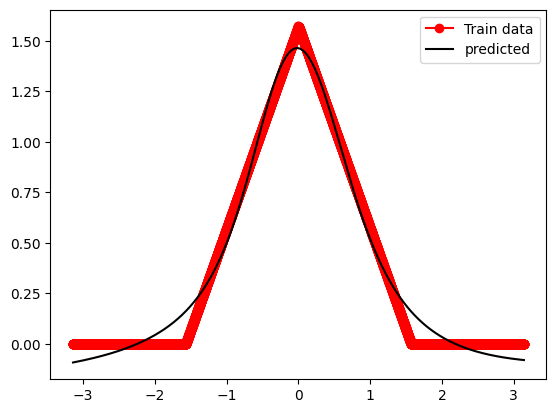

In [12]:
x_pred2 = jnp.linspace(-np.pi, np.pi, 10000)
x_pred2 = x_pred2.reshape((10000, num_features))
[y_pred2, _] = batched_prediction(params2, x_pred2)
plt.plot(x_train2, y_train2, "-ro", label="Train data")
plt.plot(x_pred2, y_pred2, "-k", label="predicted")
plt.legend()

i=0 and loss2a=Array(0.41130233, dtype=float32)

i=50000 and loss2a=Array(0.21338236, dtype=float32)

i=100000 and loss2a=Array(0.10086169, dtype=float32)

i=150000 and loss2a=Array(0.03261518, dtype=float32)

i=200000 and loss2a=Array(0.01775889, dtype=float32)



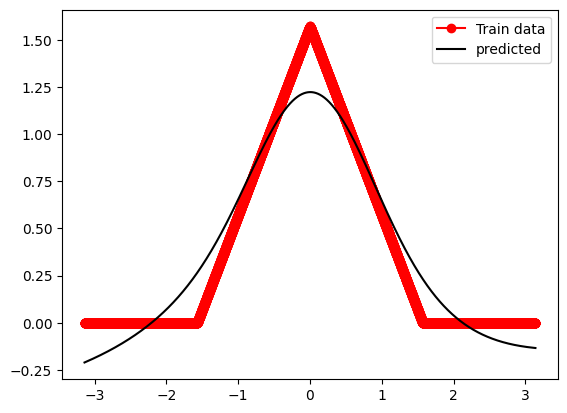

In [13]:
lr2 = 1e-04
Niter2 = 200000
layers2a = [1] + [32] + [1]
params2a = get_init_network_params(layers2a, ran_key)

for i in range(0, Niter2+1):
    params2a, loss2a, neu2a = update(params2a, x_train2, y_train2, lr2)
    
    if i % 50000 == 0:
        print(f"{i=} and {loss2a=}\n")
        
[y_pred2a, _] = batched_prediction(params2a, x_pred2)
plt.plot(x_train2, y_train2, "-ro", label="Train data")
plt.plot(x_pred2, y_pred2a, "-k", label="predicted")
plt.legend()

i=0 and loss2b=Array(0.5786562, dtype=float32)

i=50000 and loss2b=Array(0.14183438, dtype=float32)

i=100000 and loss2b=Array(0.01894065, dtype=float32)

i=150000 and loss2b=Array(0.00422084, dtype=float32)

i=200000 and loss2b=Array(0.00330581, dtype=float32)



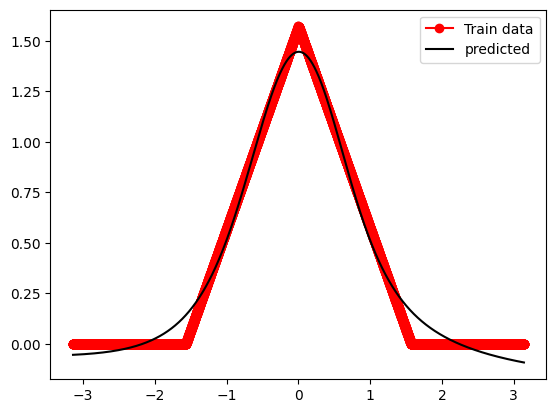

In [14]:
lr2 = 1e-04
Niter2 = 200000
layers2b = [1] + [8]*2 + [1]
params2b = get_init_network_params(layers2b, ran_key)

for i in range(0, Niter2+1):
    params2b, loss2b, neu2b = update(params2b, x_train2, y_train2, lr2)
    
    if i % 50000 == 0:
        print(f"{i=} and {loss2b=}\n")
        
[y_pred2b, _] = batched_prediction(params2b, x_pred2)
plt.plot(x_train2, y_train2, "-ro", label="Train data")
plt.plot(x_pred2, y_pred2b, "-k", label="predicted")
plt.legend()

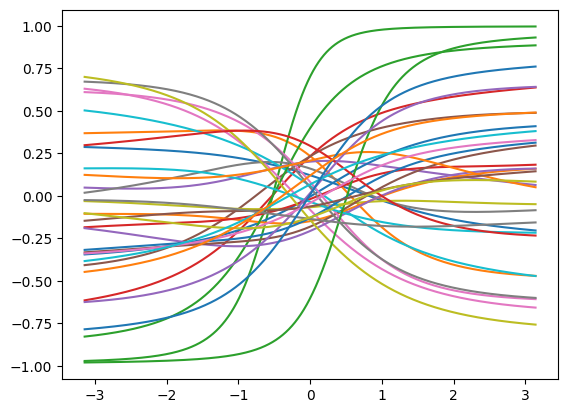

In [15]:
plt.plot(x_pred2, neu2)

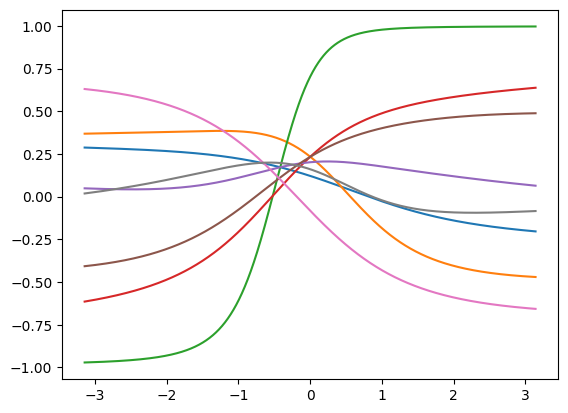

In [16]:
for i in range(8):
    plt.plot(x_pred2, neu2[:,i])

In shape, the neural network (NN) model is similar to the shape of the 0-mode of the Fourier approximation (albeit the function is better fitted by the NN). In both models, the hat (sharper slope i.e. "high frequency") is fitted first, and then the tails. The difference between the two is that the NN model is missing the higher frequency modes of the Fourier, which has successively higher frequencies of the sinusoids. This is most likely due to the fact that I used tanh as by basis function for the NN. As such, the resulting model is missing the sinusoidal shape that is present in the Fourier. If the basis I used for the NN is sin or cos, then the model may look much more similar to the Fourier, provided that there is more than a single layer to change the frequency (via the output of the previous layer) of the sinusoidal basis functions.
The "frequency change" idea has some merit, as when I decrease the number of layers from 3 to 1 (while keeping the number of neurons per layer constant at 32), the NN model is no longer able to fit the sharp slope of the "hat" function very well. When I decrease the number of neurons per layer from 32 to 8, but increase the number of layers to 2 (from 1),  the NN model is better able to deal with the sharp slope.

#### Function 3 - 9.a

In [17]:
def f3(x):
    x = np.array(x)
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0:
            j = 0
            y[i] = 5
            for j in range(5):
                y[i] += np.sin((j+1)*x[i])
        if x[i] >= 0:
            y[i] = np.cos(10*x[i])
    y = jnp.array(y)
    return y

In [18]:
import optax
import haiku as hk

In [19]:
# state = train_state.TrainState.create(
#     apply_fn=model().apply,
#     params=variables['params'],
#     tx = optax.adam(learning_rate),)
# # in conjunction with package "flax"

# loss_train_hist = []      # record loss of each batch
# loss_test_hist = []       # record loss of each batch

In [20]:
optimizer = optax.adam(lr)
layers3 = [1] + [8]*2 + [1]
params3 = get_init_network_params(layers3, ran_key)
opt_state3 = optimizer.init(params3)

In [21]:
x_train3 = x_uni(num_batches, -np.pi, np.pi)
y_train3 = f3(x_train3)
x_train3 = x_train3.reshape((num_batches, num_features))
y_train3 = y_train3.reshape((num_batches, num_features))

In [22]:
Niter3 = 100

Adam Only

In [23]:
loss_adam = np.zeros(Niter3+1)
for i in range(0, Niter3+1):
    l3, grads3 = value_and_grad(mse_loss)(params3, x_train3, y_train3)       
    updates3, opt_state3 = optimizer.update(grads3, opt_state3)
    params3 = optax.apply_updates(params3, updates3)
    loss_adam[i] = l3
    if i % 2000 == 0:
        print(f"{i=} and {l3=}\n")

i=0 and l3=Array(10.936979, dtype=float32)



In [35]:
# x_pred3 = jnp.linspace(-np.pi, np.pi, 10000)
# x_pred3 = x_pred3.reshape((10000, num_features))
# [y_pred3, _] = batched_prediction(params3, x_pred3)
# plt.plot(x_train3, y_train3, "-ro", label="Train data")
# plt.plot(x_pred3, y_pred3, "-k", label="predicted")
# plt.legend()

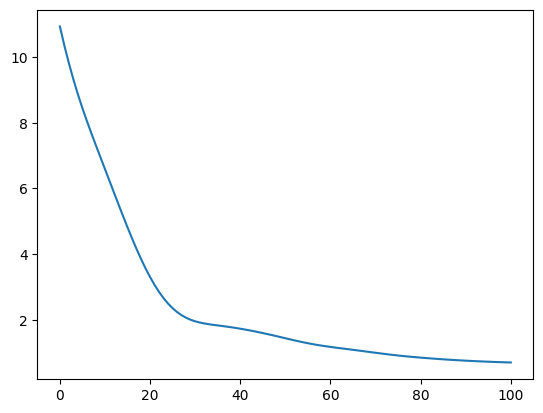

In [25]:
plt.plot(loss_adam)

L-BFGS only

In [26]:
import jaxopt

In [27]:
params3a = get_init_network_params(layers3, ran_key)

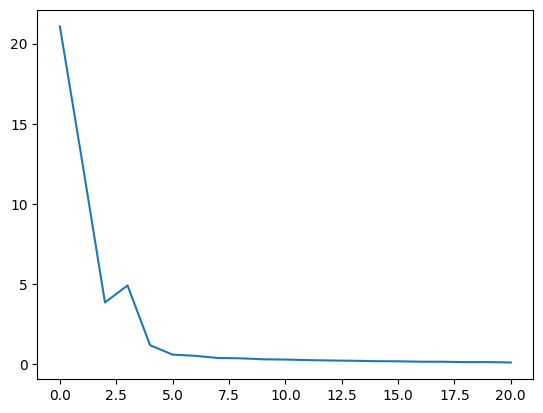

In [28]:
solver = jaxopt.LBFGS(fun=mse_loss, maxiter = 1, history_size=1, verbose=True)

Niter_bfgs = 20
loss_lbgfs = np.zeros(Niter_bfgs+1)

for i in range(Niter_bfgs+1):
    params3a, state = solver.run(params3a, x_train3, y_train3)
    loss_lbgfs[i] = solver.l2_optimality_error(params3a, x_train3, y_train3)
    # print(loss_lbgfs[i])

# params3a, state = solver.run(params3a, x_train3, y_train3)
plt.plot(loss_lbgfs)


Adam + L-BGFS

In [38]:
params3b = get_init_network_params(layers3, ran_key)
opt_state3b = optimizer.init(params3b)

In [39]:
Niter3b = 200
loss_combo = np.zeros(Niter3b+1)

for i in range(0, Niter3b+1):
    l3b, grads3b = value_and_grad(mse_loss)(params3b, x_train3, y_train3)       
    updates3b, opt_state3b = optimizer.update(grads3b, opt_state3b)
    params3b = optax.apply_updates(params3b, updates3b)
    loss_combo[i] = l3b
    
    if i > Niter3b-20:
        params3b, state3b = solver.run(params3b, x_train3, y_train3)
        loss_combo[i] = solver.l2_optimality_error(params3b, x_train3, y_train3)

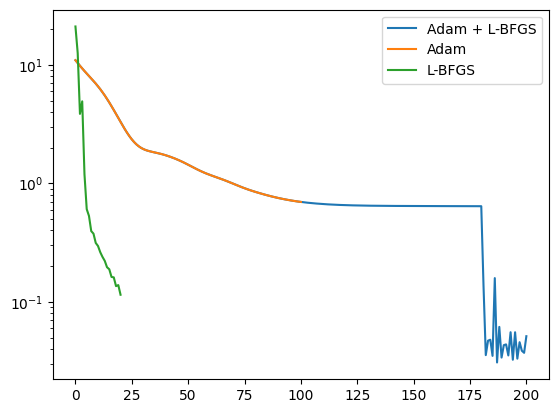

In [40]:
plt.plot(loss_combo, label = "Adam + L-BFGS")
plt.plot(loss_adam, label = "Adam")
plt.plot(loss_lbgfs, label = "L-BFGS")

plt.yscale("log")
plt.legend()


Adam (1st order) is slower at reducing training loss than L-BFGS (2nd order). With the same number of iterations, the L-BFGS after first training with Adam is much better at reducing the error than just using L-BFGS (much steeper initial loss drop). 

#### Function 4 - 9.b

In [45]:
def f4(t):
    t = np.array(t)
    y = np.zeros(len(t))
    for i in range(len(t)):

        if t[i] < 1:
            y[i] = 0
        if t[i] >= 1:
            y[i] = 1
        
    y = jnp.array(y)
    return y

In [46]:
x_train4 = x_uni(num_batches, -np.pi, np.pi)
y_train4 = f4(x_train4)
x_train4 = x_train4.reshape((num_batches, num_features))
y_train4 = y_train4.reshape((num_batches, num_features))

Adam

In [65]:
params4 = get_init_network_params(layers3, ran_key)
opt_state4 = optimizer.init(params4)

In [66]:
Niter4 = 200
loss_adam_b = np.zeros(Niter4+1)
for i in range(0, Niter4+1):
    l4, grads4 = value_and_grad(mse_loss)(params4, x_train4, y_train4)       
    updates4, opt_state4 = optimizer.update(grads4, opt_state4)
    params4 = optax.apply_updates(params4, updates4)
    loss_adam_b[i] = l4
    if i % 20 == 0:
        print(f"{i=} and {l4=}\n")

i=0 and l4=Array(0.18574977, dtype=float32)

i=20 and l4=Array(0.07311153, dtype=float32)

i=40 and l4=Array(0.05750647, dtype=float32)

i=60 and l4=Array(0.03450801, dtype=float32)

i=80 and l4=Array(0.0259357, dtype=float32)

i=100 and l4=Array(0.02028925, dtype=float32)

i=120 and l4=Array(0.01536129, dtype=float32)

i=140 and l4=Array(0.01183291, dtype=float32)

i=160 and l4=Array(0.00984826, dtype=float32)

i=180 and l4=Array(0.00852861, dtype=float32)

i=200 and l4=Array(0.0073555, dtype=float32)



L-BFGS

In [54]:
Niter_bfgs = 20
loss_lbgfs_b = np.zeros(Niter_bfgs+1)
params4a = get_init_network_params(layers3, ran_key)

for i in range(Niter_bfgs+1):
    params4a, state = solver.run(params4a, x_train4, y_train4)
    loss_lbgfs_b[i] = solver.l2_optimality_error(params4a, x_train4, y_train4)
    print(f"{i=} and {loss_lbgfs_b[i]}\n")

i=0 and 0.06527877599000931

i=1 and 0.11942729353904724

i=2 and 0.061915382742881775

i=3 and 0.10979556292295456

i=4 and 0.06357874721288681

i=5 and 0.12094767391681671

i=6 and 0.06373606622219086

i=7 and 0.11716049164533615

i=8 and 0.06709589809179306

i=9 and 0.1315426081418991

i=10 and 0.06715115904808044

i=11 and 0.12559999525547028

i=12 and 0.06884538382291794

i=13 and 0.13752490282058716

i=14 and 0.06607531756162643

i=15 and 0.12447290122509003

i=16 and 0.06432303041219711

i=17 and 0.1307951956987381

i=18 and 0.05853929743170738

i=19 and 0.1109420508146286

i=20 and 0.05428176745772362



In [67]:
params4b = get_init_network_params(layers3, ran_key)
opt_state4b = optimizer.init(params4b)

In [68]:
loss_combo_b = np.zeros(Niter4+1)

for i in range(0, Niter4+1):
    l4b, grads4b = value_and_grad(mse_loss)(params4b, x_train4, y_train4)       
    updates4b, opt_state4b = optimizer.update(grads4b, opt_state4b)
    params4b = optax.apply_updates(params4b, updates4b)
    loss_combo_b[i] = l4b
    
    if i > Niter4-20:
        params4b, state4b = solver.run(params4b, x_train4, y_train4)
        loss_combo_b[i] = solver.l2_optimality_error(params4b, x_train4, y_train4)

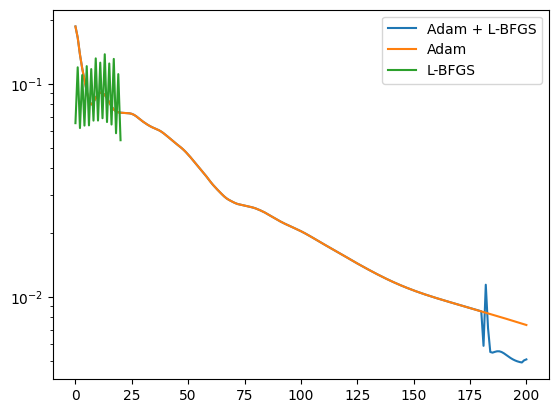

In [69]:
plt.plot(loss_combo_b, label = "Adam + L-BFGS")
plt.plot(loss_adam_b, label = "Adam")
plt.plot(loss_lbgfs_b, label = "L-BFGS")

plt.yscale("log")
plt.legend()

For function 8 (Problem 9.ii - a heaviside function), the L-BFGS on it's own is unable to reduce the training loss, and is likely stuck in a local minima. Adam is able to reduce the training loss much furter, and switching to an L-BFGS optimizer after the initial Adam training further produces a steep drop in the training loss.